# Extract features for linear regression model to predict the migration of inhabitants between district A and district B

Features to extract:
* Density of population per year per district for district A and B (control of correct normalization)
* Average net income level for district A and B
* Number of AirBnB listings/1000 inhabitants for district A and B
* Percentage of variation of AirBnB listings with respect to previous year for district A and B
* Unemployment rates (%) per district for district A and B
* Percentage of the population older than 65 per district for district A and B
* Inner degree of previous year/number of inhabitants for district A and B
* Outer degree of previous year/number of inhabitants for district A and B
* Percent of variation on businesses registered per year for all Madrid
* Percent of variation on price of sale m2 per district per year for district A and B (restricted to 2007 on)
* Percent of variation on price of rent m2 per district per year for district A and B (restricted to 2007 on)
* Number of real state transactions per 1000 inhabitants per district per year for district A and B 
* Number of real state transactions per 1000 inhabitants of new houses per district per year for district A and B
* Number of evictions per year

Target migrations will be normalized by the number of inhabitants in origin and destination in order to have a better representation of the weight of the migrant flow.

Preprocessing of the data used in this notebook is done in https://github.com/diazcelsa/visualizations

Data sources are:
* Data Bank from the City of Madrid
* Spanish National Institute of Statistics (INE)
* Inside Airbnb
* Idealista

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
biz_evol = pd.read_csv("./data/companies_registered_madrid.csv")
census = pd.read_csv("./data/complete_clean_census_madrid.csv")
census_agg = pd.read_csv("./data/census_madrid_agg_segments.csv")
unemploy = pd.read_csv("./data/unemployment_complete.csv", sep="\t")
inhab_evol = pd.read_csv("./data/evolution_inhabitants_madrid.csv")
migrations_degree = pd.read_csv("./data/migrations_degree_madrid.csv")
total_income = pd.read_csv("./data/net_income_classification_mad.csv")
district_income = pd.read_csv("./data/net_income_district_14.csv")
euribor = pd.read_csv('./data/euribor_es.csv')
airbnb = pd.read_csv("./data/airbnb_complete.csv")
n_business = pd.read_csv("./data/companies_registered_madrid.csv", sep="\t")
rent_price = pd.read_csv("./data/rent_price_m2_districts_ratio.csv")
sale_price = pd.read_csv("./data/sale_price_m2_districts_ratio.csv")
vicalvaro_prices = pd.read_csv("./data/complete_vicalvaro.csv")
migrations = pd.read_csv("./data/migrations_complete_madrid.csv")
real_st_trans = pd.read_csv("./data/total_housing_madrid_clean.csv")
real_st_trans_new = pd.read_csv("./data/new_housing_madrid_clean.csv")
mortage_executions = pd.read_csv("./data/c_madrid_ejec_hipotec_cgpj.csv")

### Build features

###### 1. Total number of inhabitants per year per district

In [6]:
n_inh_dist_year = census_agg.loc[:,("district","year","total")].groupby(["district","year"], as_index=False).sum()
n_inh_dist_year = n_inh_dist_year.rename(columns={"total":"n_inhabitants"})

In [7]:
n_inh_dist_year.district.unique()

array(['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín',
       'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza',
       'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas',
       'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera',
       'Vicálvaro', 'Villa de Vallecas', 'Villaverde'], dtype=object)

In [8]:
density = pd.DataFrame({"district": ['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín',
       'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza',
       'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas',
       'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera',
       'Vicálvaro', 'Villa de Vallecas', 'Villaverde'],
        "density": [235.16,11.18,173.68,252.34,156.31,293.64,186.01,10.04,65.81,91.95,
         25.12,154.34,152.05,216.82,266.67,69.24,286.13,173.30,19.86,19.86,
         70.64]})

In [9]:
dist_size = n_inh_dist_year.groupby(["district"], as_index=False).mean()
dist_size["dist_size"] = dist_size["n_inhabitants"]/dist_size["n_inhabitants"].sum()
dist_size = dist_size.loc[:,("district","dist_size")]

###### 2. Average net income per district

In [10]:
net_inc_dist = total_income.loc[:,("district","net_income (euros)")]
net_inc_dist = net_inc_dist.rename(columns={"net_income (euros)":"net_income"})

###### 3. Ratio of number of reviews per 1000 inhabitants per district per year

In [11]:
# Extract year of review and drop data for 2018
airbnb['date_review_year'] = pd.to_datetime(airbnb['date_review']).dt.year
airbnb['date_review_year'] = airbnb['date_review_year'].fillna(0).astype(int)
airbnb = airbnb[airbnb["date_review_year"] != 2018]

# get all reviews per year per neighbourhood
review_year = airbnb.loc[:,("neighbourhood_group_cleansed","date_review_year","listing_id")]\
                    .groupby(["neighbourhood_group_cleansed","date_review_year"]).count().reset_index()
review_year = review_year.rename(columns={"neighbourhood_group_cleansed":"district","date_review_year":"year",
                                          "listing_id":"n_airbnb_rev"})

# calculate number of reviews per district per 1000 inhabitants
rev_inha = n_inh_dist_year.merge(review_year, how="left", left_on=["district","year"], 
                            right_on=["district","year"])\
                            .loc[:,("district","year","n_inhabitants","n_airbnb_rev")]\
                            .fillna(0)
rev_inha['rev_1000_inh'] = rev_inha['n_airbnb_rev']/rev_inha['n_inhabitants']*1000
rev_inha_ = rev_inha.loc[:,("district","year","rev_1000_inh")]

###### 4. Percentage of variation on AirBnB reviews regarding the previous year

In [12]:
# calculate difference with previous year
rev_inh_agg = rev_inha.loc[:,["district","year","n_airbnb_rev"]].groupby(["district"])

years = []
districts = []
variation = []
for index, df in rev_inh_agg:
    n_reviews = df["n_airbnb_rev"].values
    percent_var = []
    percent_var.append(0)
    for value in range(1,len(n_reviews)):
        if n_reviews[value-1] == 0 or n_reviews[value] == 0:
            percent_var.append(0)
        else:
            var = (n_reviews[value]-n_reviews[value-1]) * 100 / n_reviews[value-1]
            percent_var.append(var)
    districts.append(index)
    variation.append(percent_var)
    years = df["year"].tolist()
    
# build percentage of variation data frame
rev_dict = []
years_ = [years for i in range(len(variation))]
for i in range(len(variation)):
    rev_dict.append(dict(zip(years_[i], variation[i])))
var_rev_perc = pd.DataFrame(rev_dict, index=districts)
var_rev_perc = var_rev_perc.unstack().reset_index().rename(columns={"level_0":"year","level_1":"district",
                                                                      0:"var_review"})

###### 5. Unemployment rates per district

In [13]:
unemploy = unemploy.set_index("year").unstack().reset_index().rename(columns={"level_0":"district",0:"unemployed"})

###### 6. Percentage of the population with more than 65 years

In [14]:
# calculate percentage of population older than 65 for each district and year
eldery_inhab_dist = census_agg[census_agg["age_range"].isin(['65-84', '85-100'])].loc[:,("district","year","total")]\
                        .groupby(["district","year"], as_index=False).sum().rename(columns={"total":"eldery"})
total_inhab_dist = census_agg[census_agg["age_range"]=="Total"].loc[:,("district","year","total")]
ratio_eldery_inha = eldery_inhab_dist.merge(total_inhab_dist, left_on=["district","year"], 
                                            right_on=["district","year"])

ratio_eldery_inha["eldery_perc"] = ratio_eldery_inha["eldery"] * 100 / ratio_eldery_inha["total"]
ratio_eldery_inha = ratio_eldery_inha.loc[:,("district","year","eldery_perc")]

###### 7. Inner and outer degree per neighbourhood

In [15]:
# Build degrees vector to be normalized by the number of inhabitants
district_degrees = migrations_degree.loc[:,("district","year","d_inner","d_outer")]
district_degrees = district_degrees.merge(n_inh_dist_year, left_on=["district","year"], right_on=["district","year"])
dist_deg_agg = district_degrees.groupby(["district"])

degrees_norm = []
for i, df in dist_deg_agg:
    df = df.sort_values(by="year").reset_index(drop=True)
    
    ratios_inner = []
    ratios_inner.append(0)
    ratios_outer = []
    ratios_outer.append(0)
    for i in range(1, len(df)):
        var_inner = df.loc[i,"d_inner"]*100/df.loc[i-1,"n_inhabitants"]
        var_outer = df.loc[i,"d_outer"]*100/df.loc[i-1,"n_inhabitants"]
        ratios_inner.append(var_inner)
        ratios_outer.append(var_outer)
        
    # In order to avoid having 0 in the first year, we just "wrongly" take the gradients of the second year (2008)
    ratios_inner[0] = ratios_inner[1]
    ratios_outer[0] = ratios_outer[1]
    
    df["d_inner_n"] = ratios_inner
    df["d_outer_n"] = ratios_outer
    degrees_norm.append(df)

degrees_norm = pd.concat(degrees_norm).reset_index(drop=True)
degrees_norm = degrees_norm.loc[:,("district","year","d_inner_n","d_outer_n")]

###### 8. Ratio of growth ratio of number of business registered in Madrid in comparison to previous year

In [16]:
# Calculate growth variation
n_business_ = n_business.T.reset_index().rename(columns={"index":"year",0:"n_business"})
n_business_ = n_business_[n_business_["year"] != "1999"]
n_business_ = n_business_.sort_values(by="year").reset_index(drop=True)
variation = []
variation.append(0)
for i in range(1, len(n_business_)):
    var = (n_business_.loc[i,"n_business"]-n_business_.loc[i-1,"n_business"])*100/n_business_.loc[i-1,"n_business"]
    variation.append(var)
n_business_["var_n_biz"] = variation
n_business_["year"] = n_business_["year"].astype(int)
n_business_ = n_business_.loc[:,("year","var_n_biz")]

###### 9. Sale growth price rate of m2 per district

In [17]:
# Calculate rate of variation per year per district
sale_price = sale_price[sale_price["district"] != "madrid"]
sale_agg = sale_price.loc[:,("district","year","price_m2")]

# Add data from vicalvaro
vicalvaro_m2 = vicalvaro_prices.T.reset_index().iloc[1:]
vicalvaro_m2.columns = vicalvaro_prices.T.reset_index().iloc[0]
vicalvaro_m2["district"] = "vicálvaro"
vicalvaro_rent = vicalvaro_m2.loc[:,("district","year","m2_price_rent")].rename(columns={"m2_price_rent":"price_m2"})
vicalvaro_sale = vicalvaro_m2.loc[:,("district","year","m2_price_sale")].rename(columns={"m2_price_sale":"price_m2"})
sale_agg = pd.concat([sale_agg,vicalvaro_sale])

sale_agg = sale_agg.groupby(["district"], as_index=False)

growth_var = []
for i, df in sale_agg:
    df = df.sort_values(by="year").reset_index(drop=True)

    variation = []
    variation.append(0)
    for i in range(1, len(df)):
        var = (df.loc[i,"price_m2"]-df.loc[i-1,"price_m2"])*100/df.loc[i-1,"price_m2"]
        variation.append(var)
        
    # In order to avoid having 0 in the first year, we just "wrongly" take the gradients of the second year (2008)
    variation[0] = variation[1]
    
    df["var_sale_m2"] = variation
    growth_var.append(df)
sale_m2_var = pd.concat(growth_var).reset_index(drop=True)
sale_m2_var = sale_m2_var.loc[:,("district","year","var_sale_m2")]

# update district names to match the rest of data sources
mapper = dict(zip(['arganzuela', 'barajas', 'carabanchel', 'centro', 'chamartín',
       'chamberí', 'ciudad lineal', 'fuencarral', 'hortaleza', 'latina','moncloa', 
       'moratalaz', 'puente de vallecas', 'retiro',
       'salamanca', 'san blas', 'tetuán', 'usera', 'villa de vallecas',
       'vicálvaro', 'villaverde'],['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín',
       'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza',
       'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas',
       'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera', 'Villa de Vallecas',
       'Vicálvaro','Villaverde']))
sale_m2_var["district"] = sale_m2_var["district"].apply(lambda x: mapper[x])
sale_m2_var["year"] = sale_m2_var["year"].astype(int)

###### 10. Rent growth price rate of m2 per district 

In [18]:
# Calculate rate of variation per year per district
rent_price = rent_price[rent_price["district"] != "madrid"]
rent_agg = rent_price.loc[:,("district","year","price_m2")]
rent_agg = pd.concat([rent_agg,vicalvaro_rent])
rent_agg = rent_agg.groupby(["district"], as_index=False)

growth_var = []
for i, df in rent_agg:
    df = df.sort_values(by="year").reset_index(drop=True)
    
    variation = []
    variation.append(0)
    for i in range(1, len(df)):
        var = (df.loc[i,"price_m2"]-df.loc[i-1,"price_m2"])*100/df.loc[i-1,"price_m2"]
        variation.append(var)
        
    # In order to avoid having 0 in the first year, we just "wrongly" take the gradients of the second year (2008)
    variation[0] = variation[1]
    
    df["var_rent_m2"] = variation
    growth_var.append(df)
rent_m2_var = pd.concat(growth_var).reset_index(drop=True)
rent_m2_var["district"] = rent_m2_var["district"].apply(lambda x: mapper[x])
rent_m2_var = rent_m2_var.loc[:,("district","year","var_rent_m2")]
rent_m2_var["year"] = rent_m2_var["year"].astype(int)

###### 11. Number of real state transactions 

In [19]:
real_st_trans_ = real_st_trans.T.iloc[1:]
real_st_trans_.columns = real_st_trans.T.iloc[0]
real_st_trans_ = real_st_trans_.unstack().reset_index().rename(columns={"level_1":"year",0:"n_tran_rs"})
mapper_2 = dict(zip(['Centro', 'Arganzuela', 'Retiro', 'Salamanca', 'Chamartín',
       'Tetuán', 'Chamberí', 'Fuencarral', 'Moncloa', 'Latina',
       'Carabanchel', 'Usera', 'Puente de Vallecas', 'Moratalaz',
       'Ciudad Lineal', 'Hortaleza', 'Villaverde', 'Villa de Vallecas',
       'Vicálvaro', 'Barajas','San Blas'],
         ['Centro','Arganzuela', 'Retiro', 'Salamanca', 'Chamartín', 'Tetuán',
          'Chamberí','Fuencarral - El Pardo',  'Moncloa - Aravaca', 'Latina','Carabanchel', 
          'Usera','Puente de Vallecas','Moratalaz','Ciudad Lineal', 'Hortaleza', 'Villaverde',
          'Villa de Vallecas','Vicálvaro','Barajas','San Blas - Canillejas']))
real_st_trans_["district"] = real_st_trans_["district"].apply(lambda x: mapper_2[x])
real_st_trans_["n_tran_rs"] = real_st_trans_["n_tran_rs"].astype(float)
real_st_trans_["year"] = real_st_trans_["year"].astype(int)

###### 12. Number of real state transactions of new houses

In [20]:
real_st_trans_new_ = real_st_trans_new.T.iloc[1:]
real_st_trans_new_.columns = real_st_trans_new.T.iloc[0]
real_st_trans_new_ = real_st_trans_new_.unstack().reset_index().rename(columns={"level_1":"year",0:"n_tran_new_rs"})
real_st_trans_new_["district"] = real_st_trans_new_["district"].apply(lambda x: mapper_2[x])
real_st_trans_new_["n_tran_new_rs"] = real_st_trans_new_["n_tran_new_rs"].astype(float)
real_st_trans_new_["year"] = real_st_trans_new_["year"].astype(int)

###### 13. Number of mortage executions

In [21]:
mortage_executions['mortage_executions'] = mortage_executions['mortage_executions'].astype(int)

###### 14. Euribor

In [22]:
euribor = euribor.T.reset_index(drop=True).loc[1:,:].rename(columns={0:'year',1:'euribor'})
euribor['year'] = euribor['year'].astype(int)
euribor['euribor'] = euribor['euribor'].astype(float)

### Build feature vector for all migrations

For each migration build:
* features for orgin district in the given year
* features for destination district in the given year
* split origin, destination and year from features with same indexes

In [23]:
# Merge all the features for a given district and a given year
feature_vector = n_inh_dist_year.merge(net_inc_dist, left_on="district", right_on="district")
feature_vector = feature_vector.merge(euribor, left_on="year", right_on="year")
feature_vector = feature_vector.merge(density, left_on="district", right_on="district")
feature_vector = feature_vector.merge(rev_inha_, left_on=["district", "year"], 
                                      right_on=["district", "year"])
feature_vector = feature_vector.merge(var_rev_perc, left_on=["district","year"], right_on=["district","year"])
feature_vector = feature_vector.merge(unemploy, left_on=["district","year"], right_on=["district","year"])
feature_vector = feature_vector.merge(ratio_eldery_inha, left_on=["district","year"], right_on=["district","year"])
feature_vector = feature_vector.merge(degrees_norm, left_on=["district","year"], right_on=["district","year"])
feature_vector = feature_vector.merge(n_business_, left_on="year", right_on="year")
feature_vector = feature_vector.merge(sale_m2_var, left_on=["district","year"], right_on=["district","year"])
feature_vector = feature_vector.merge(rent_m2_var, left_on=["district","year"], right_on=["district","year"])
feature_vector = feature_vector.merge(real_st_trans_, left_on=["district","year"], right_on=["district","year"])
feature_vector = feature_vector.merge(real_st_trans_new_, left_on=["district","year"], right_on=["district","year"])
feature_vector = feature_vector.merge(mortage_executions, left_on="year", right_on="year")

In [24]:
feature_vector.year.unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

### Normalization of features and migrations by the total number of inhabitants

In [25]:
# Adjust feature of unemployment from number of unemployed per district per year to
# percentage of unemployed per district per year normalized by the number of inhabitants
feature_vector["unemployed"] = feature_vector["unemployed"] / feature_vector["n_inhabitants"] * 100

In [26]:
# Normalize real state transactions per 1000 inhabitants in each district and year
f_vector = []
for i in range(len(feature_vector)):
    df = feature_vector.loc[i]
    district = df["district"]
    year = df["year"]
    prev = feature_vector[(feature_vector["district"]==district) & (feature_vector["year"]==year-1)]
    
    if len(prev) != 0:
        #import pdb; pdb.set_trace()
        df["n_tran_rs"] = df["n_tran_rs"]/prev["n_inhabitants"].values[0]*1000
    else:
        df["n_tran_rs"] = df["n_tran_rs"]/df["n_inhabitants"]*1000
    f_vector.append(df)
feature_vector = pd.concat(f_vector, axis=1).T
dtype_cols = ['n_inhabitants', 'net_income', 'rev_1000_inh','var_review', 'unemployed', 'eldery_perc', 
              'd_inner_n', 'd_outer_n','var_n_biz']
feature_vector['year'] = feature_vector['year'].astype(int)
for col in dtype_cols:
    feature_vector[col] = feature_vector[col].astype(float)

In [27]:
# Normalize new real state transactions per 1000 inhabitants in each district and year
f_vector = []
for i in range(len(feature_vector)):
    df = feature_vector.loc[i]
    district = df["district"]
    year = df["year"]
    prev = feature_vector[(feature_vector["district"]==district) & (feature_vector["year"]==year-1)]
    
    if len(prev) != 0:
        #import pdb; pdb.set_trace()
        df["n_tran_new_rs"] = df["n_tran_new_rs"]/prev["n_inhabitants"].values[0]*1000
    else:
        df["n_tran_new_rs"] = df["n_tran_new_rs"]/df["n_inhabitants"]*1000
    f_vector.append(df)
feature_vector = pd.concat(f_vector, axis=1).T
dtype_cols = ['n_inhabitants', 'net_income', 'rev_1000_inh','var_review', 'unemployed', 'eldery_perc', 
              'd_inner_n', 'd_outer_n','var_n_biz']
feature_vector['year'] = feature_vector['year'].astype(int)
for col in dtype_cols:
    feature_vector[col] = feature_vector[col].astype(float)

In [28]:
# Discard those migrations produced within the same district
migrations = migrations[migrations["origin"] != migrations["destination"]]
migrations = migrations[(migrations["origin"] != 'external') & (migrations["destination"] != 'external')]

Text(0.5,1,'Average number of migrations per year')

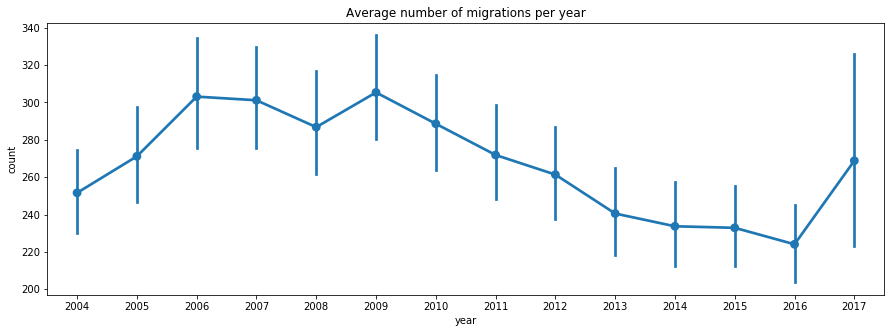

In [29]:
plt.figure(figsize=(15,5))
sns.pointplot(y='count',x='year',data=migrations)
plt.title('Average number of migrations per year')

In [30]:
# build final feature vector for each migration event
fv_complete = migrations.merge(feature_vector, left_on=["origin","year"], right_on=["district","year"])
fv_complete = fv_complete.merge(feature_vector, left_on=["destination","year"], right_on=["district","year"])
fv_complete = fv_complete.rename(columns={'n_inhabitants_y':'n_inhabitants_de','n_inhabitants_x':'n_inhabitants_or',
                                          "density_y":"density_de", "density_x":"density_or",
                                          'net_income_y':'net_income_de','net_income_x':'net_income_or',
                                          'rev_1000_inh_y':'rev_1000_inh_de', 'rev_1000_inh_x':'rev_1000_inh_or', 
                                          'var_review_y':'var_review_de', 'var_review_x':'var_review_or',
                                          'unemployed_y':'unemployed_de', 'unemployed_x':'unemployed_or',
                                          'eldery_perc_y':'eldery_perc_de', 'eldery_perc_x':'eldery_perc_or', 
                                          'd_inner_n_y':'d_inner_n_de', 'd_inner_n_x':'d_inner_n_or',
                                          'd_outer_n_y':'d_outer_n_de', 'd_outer_n_x':'d_outer_n_or',
                                          "var_sale_m2_y":"var_sale_m2_de","var_sale_m2_x":"var_sale_m2_or",
                                          "var_rent_m2_y":"var_rent_m2_de","var_rent_m2_x":"var_rent_m2_or",
                                          "n_tran_rs_y":"n_tran_rs_de","n_tran_rs_x":"n_tran_rs_or",
                                          "n_tran_new_rs_y":"n_tran_new_rs_de","n_tran_new_rs_x":"n_tran_new_rs_or"})
fv_complete = fv_complete.drop(["district_x","district_y",'euribor_y','var_n_biz_y','mortage_executions_y'], 
                               axis=1).rename(columns={"count":"migrations",'var_n_biz_x':'var_n_biz',
                                                       "mortage_executions_x":'mortage_executions','euribor_x':'euribor'})

In [31]:
# Normalize migrations by number of inhabitants in origin and destination
fv_complete["migrations"] = fv_complete["migrations"] / \
                            (fv_complete["n_inhabitants_or"]*fv_complete["n_inhabitants_de"])*1e8

In [32]:
fv_complete.loc[:,("origin","destination","year","migrations")].to_csv("./data/migrations_madrid_normalized.csv",
                                                                      index=False, encoding="utf-8")

In [33]:
origin = ['net_income_or', 'density_or', 'rev_1000_inh_or', 'var_review_or',
       'unemployed_or', 'eldery_perc_or', 'd_inner_n_or', 'd_outer_n_or',
       'var_sale_m2_or', 'var_rent_m2_or', 'n_tran_rs_or','n_tran_new_rs_or']
destination = ['net_income_de', 'density_de', 'rev_1000_inh_de', 'var_review_de',
       'unemployed_de', 'eldery_perc_de', 'd_inner_n_de', 'd_outer_n_de',
       'var_sale_m2_de', 'var_rent_m2_de', 'n_tran_rs_de', 'n_tran_new_rs_de']
difference = ['net_income_diff', 'density_diff', 'rev_1000_inh_diff', 'var_review_diff',
       'unemployed_diff', 'eldery_perc_diff', 'd_inner_n_diff', 'd_outer_n_diff',
       'var_sale_m2_diff', 'var_rent_m2_diff', 'n_tran_rs_diff','n_tran_new_rs_diff']

In [34]:
for i in range(len(origin)):
    fv_complete[difference[i]] = fv_complete[destination[i]] - fv_complete[origin[i]]

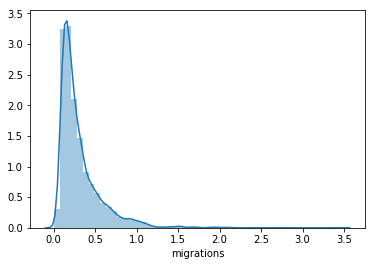

In [35]:
sns.distplot(fv_complete.migrations)

In [36]:
fv_complete.to_csv("./data/feature_vector_complete.csv", index=False, encoding="utf-8")

### Add manual labels for exploration

* Classify migrations by net income level of origin (0-28K, 28K-40K, 40K-)
* Classify migrations by time as before and after the crisis (splitting by 2011)

In [37]:
fv_complete_exp = fv_complete.copy()
fv_complete_exp["label"] = "low"
middle = (fv_complete_exp["net_income_or"] > 28000) & (fv_complete_exp["net_income_or"] < 40000)
high = (fv_complete_exp["net_income_or"] > 40000)

# Assign labels based on conditions
fv_complete_exp.loc[fv_complete_exp[middle].index,"label"] = "middle"
fv_complete_exp.loc[fv_complete_exp[high].index,"label"] = "high"

Color labels:
* Low income: green
* Middle income: blue
* High income: orange

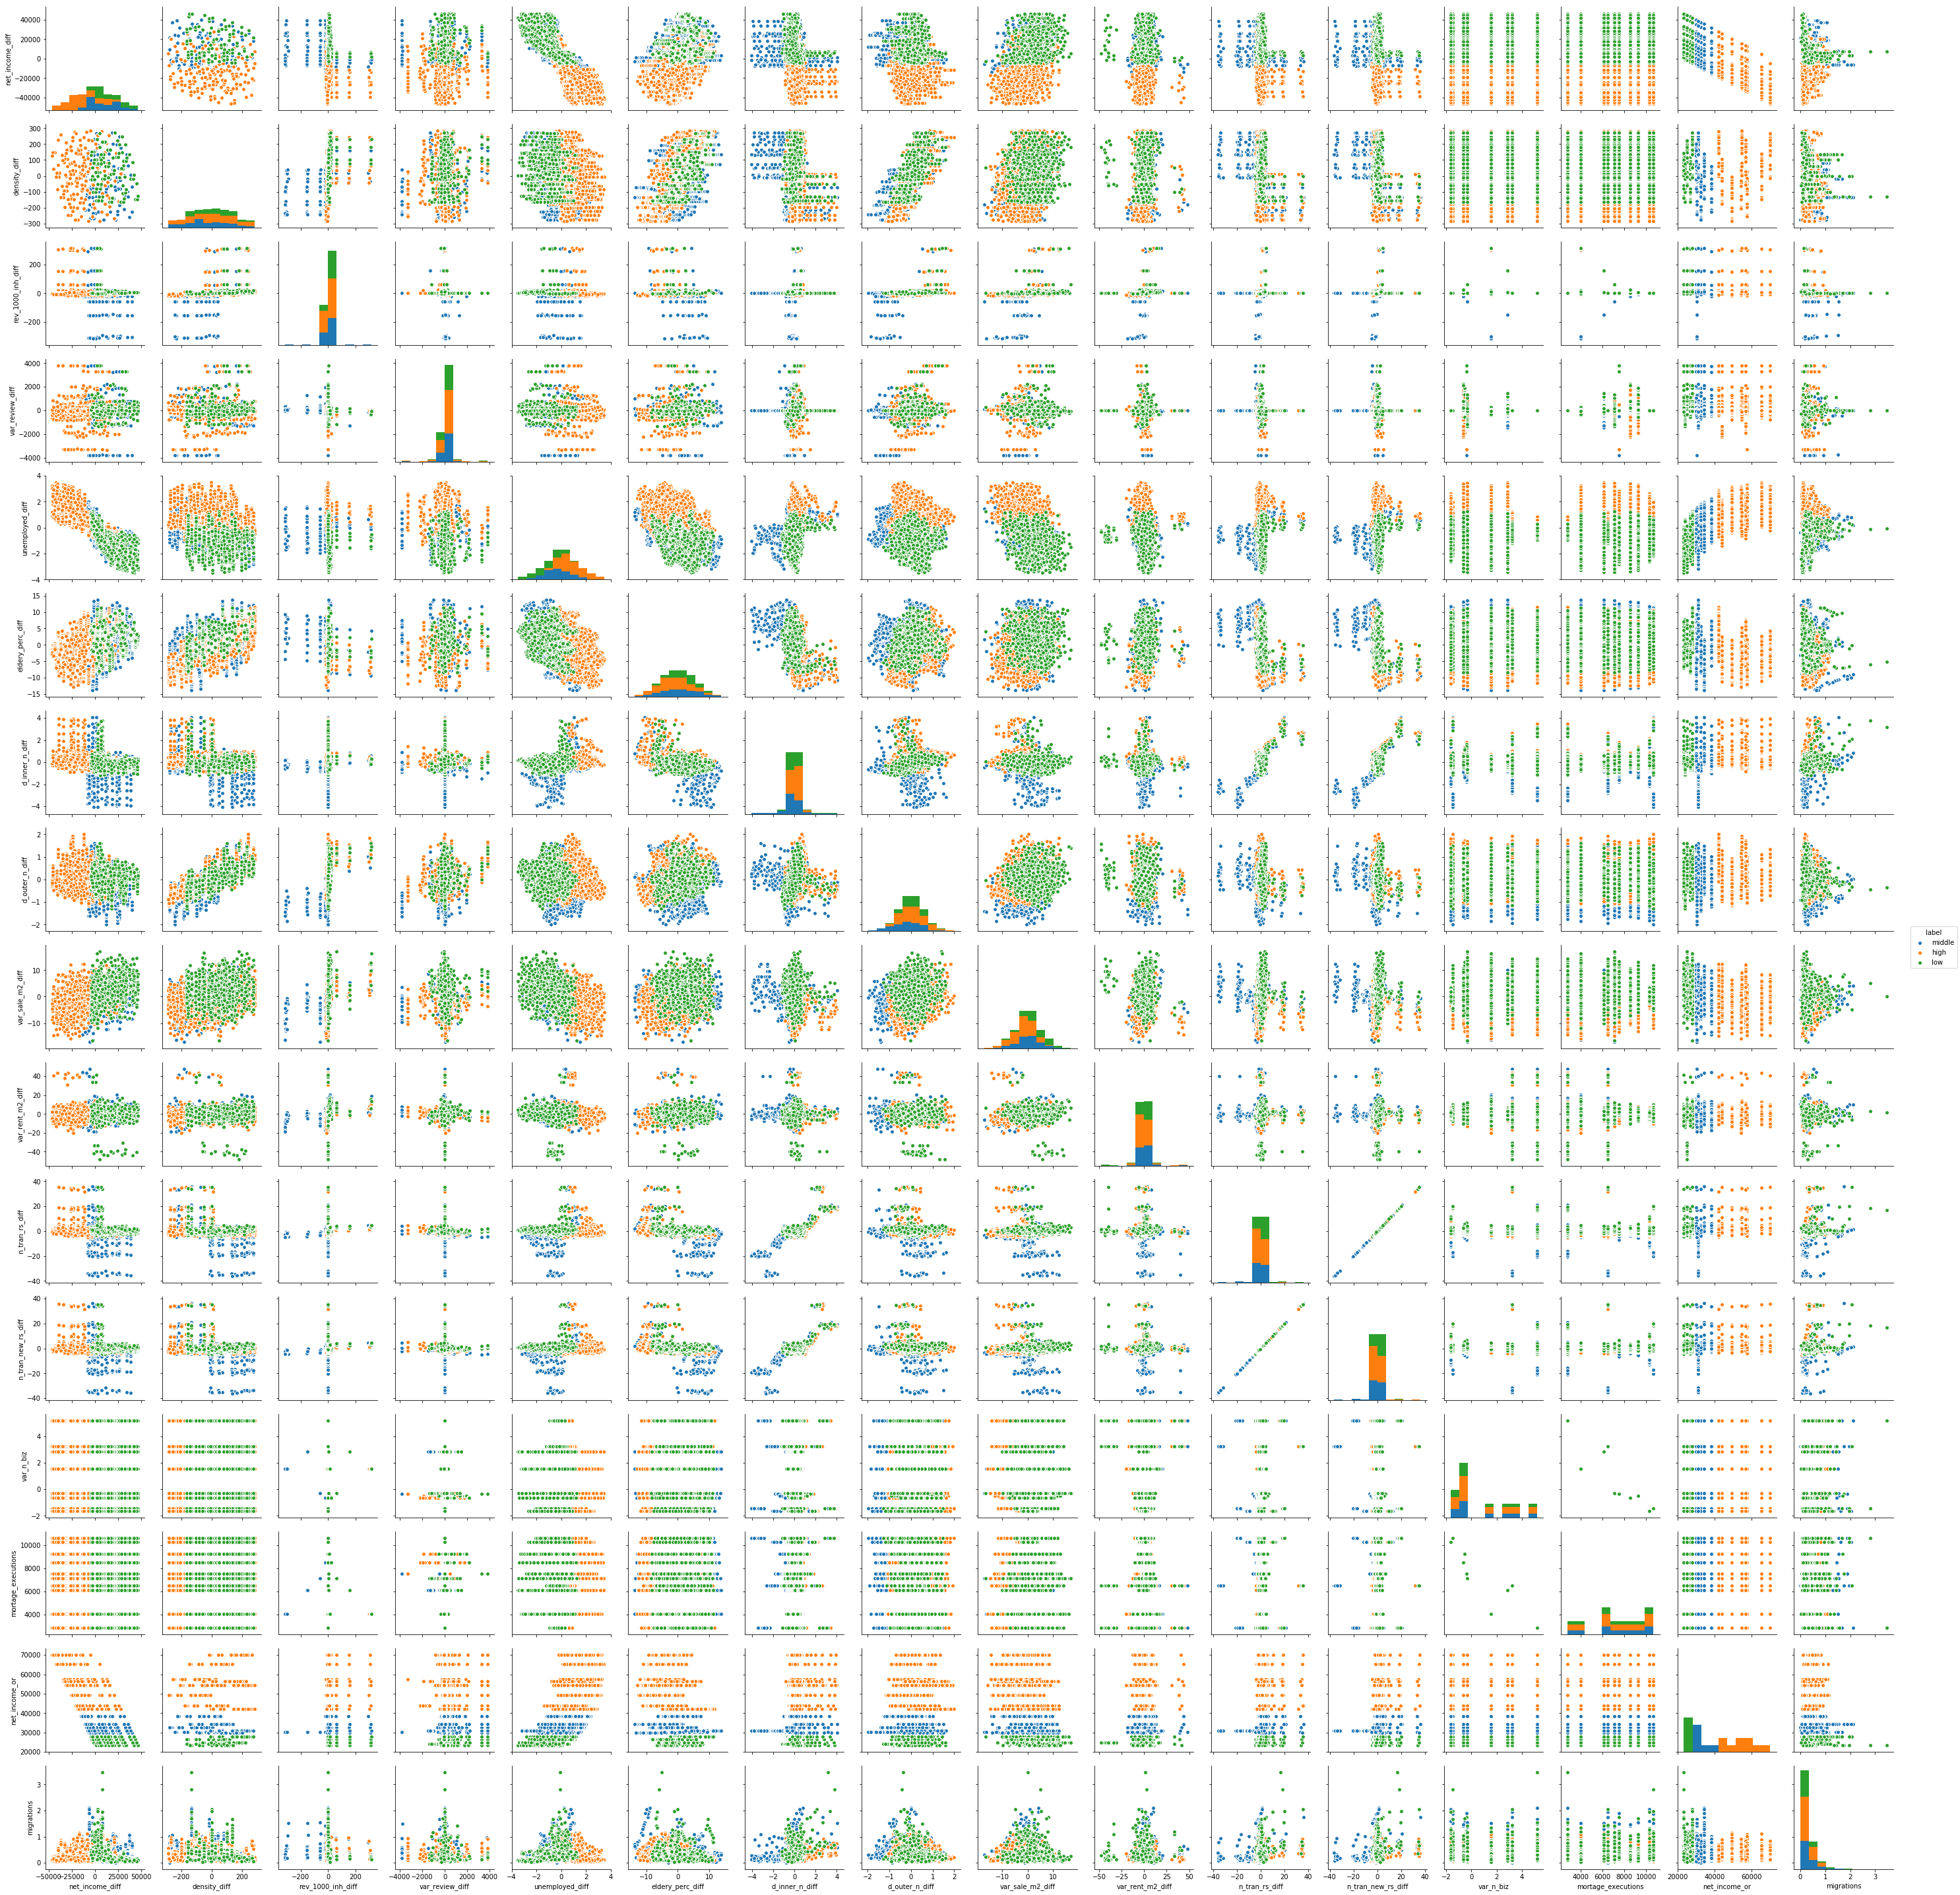

In [38]:
sns.pairplot(fv_complete_exp.loc[:,difference+["var_n_biz","mortage_executions","net_income_or",
                                               "label","migrations"]], hue="label")